## Imports et Configuration

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import numpy as np
from PIL import Image
import time
import os
import copy

# Configuration
CONFIG = {
    'img_size': 128,
    'embed_dim': 128,        # Taille vecteur latent z
    'num_classes': 3,        # 0: Alert, 1: Drowsy, 2: Distracted
    'recursion_depth': 4,    # Nombre d'itérations du TRM (n)
    'batch_size': 32,
    'lr': 1e-3,
    'epochs': 300,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'save_path': 'best_trm_model.pth'
}

print(f"Utilisation du device : {CONFIG['device']}")

Utilisation du device : cuda


### Architecture TRM (Tiny Recursive Model)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# ==========================================
# ARCHITECTURE HYBRIDE : MobileNetV3 + TRM
# ==========================================

class PretrainedVisualEmbedding(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        # 1. Chargement de MobileNetV3 Small (Pré-entraîné ImageNet)
        weights = models.MobileNet_V3_Small_Weights.DEFAULT
        self.backbone = models.mobilenet_v3_small(weights=weights)
        
        # 2. Extraction des features (on retire le classifier final)
        # La sortie de MobileNetV3-Small est généralement de 576 canaux
        self.features = self.backbone.features
        
        # 3. Adaptateur : Conv 1x1 pour réduire 576 -> 128 (embed_dim)
        # + Normalisation pour stabiliser l'entrée du Transformer
        self.adapter = nn.Sequential(
            nn.Conv2d(576, output_dim, 1),
            nn.GroupNorm(8, output_dim),
            nn.ReLU6()
        )
        
        # 4. Pooling adaptatif pour forcer une grille 8x8 (64 patches)
        # Peu importe la taille d'entrée, on aura toujours 8x8 tokens
        self.pool = nn.AdaptiveAvgPool2d((8, 8))
        
        # OPTIONNEL : Geler les premières couches pour ne pas casser les features bas niveau
        # Ici on gèle les 9 premiers blocs sur 13
        for param in self.features[:9].parameters():
            param.requires_grad = False

    def forward(self, x):
        # x: [Batch, 3, 128, 128]
        x = self.features(x)      # -> [Batch, 576, H', W']
        x = self.adapter(x)       # -> [Batch, 128, H', W']
        x = self.pool(x)          # -> [Batch, 128, 8, 8]
        
        B, C, H, W = x.shape
        # Aplatissement pour le Transformer: [Batch, 64, 128]
        # Permute pour avoir (Batch, Seq_Len, Dim)
        x = x.view(B, C, -1).permute(0, 2, 1)
        return x

class AttentionTRMBlock(nn.Module):
    def __init__(self, embed_dim, num_classes, num_heads=4, attn_dropout=0.1):
        super().__init__()
        self.attn_norm = nn.LayerNorm(embed_dim)
        
        # MHA avec batch_first=True
        self.attn = nn.MultiheadAttention(embed_dim, num_heads=num_heads, 
                                          dropout=attn_dropout, batch_first=True)
        
        self.ffn_norm = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 2),
            nn.GELU(),
            nn.Dropout(attn_dropout),
            nn.Linear(embed_dim * 2, embed_dim)
        )
        self.head = nn.Linear(embed_dim, num_classes)
        
        # Gating Scalaire (Vanne)
        self.gate = nn.Parameter(torch.tensor([0.0])) 
        # Scaling pour piquer l'attention
        self.scale = nn.Parameter(torch.tensor([0.5]))

    def forward(self, tokens, z_prev):
        # tokens: [B, 65, D] (CLS + 64 patches)
        
        # Injection contrôlée
        g = torch.sigmoid(self.gate)
        z_curr = z_prev + g * tokens
        
        z_norm = self.attn_norm(z_curr)
        
        # Sharpening (Temperature Scaling)
        q = k = v = z_norm / self.scale.clamp(min=0.1)
        
        # Attention
        attn_out, attn_weights = self.attn(q, k, v, average_attn_weights=False)
        
        z_curr = z_curr + attn_out
        z_curr = z_curr + self.ffn(self.ffn_norm(z_curr))
        
        # Classification via [CLS] (indice 0)
        cls_tok = z_curr[:, 0, :] 
        y_logits = self.head(cls_tok)
        
        return z_curr, y_logits, attn_weights

class DriverTRM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embed_dim = config['embed_dim']
        self.H = self.W = 8 # Grille 8x8 imposée par le pooling
        
        # --- CHANGEMENT : MOBILE NET ---
        self.embedding = PretrainedVisualEmbedding(self.embed_dim)
        # -------------------------------
        
        # Token [CLS]
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.embed_dim) * 0.02)
        
        # Positional Embedding (1 CLS + 64 Patches)
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + self.H*self.W, self.embed_dim) * 0.02)
        
        self.trm_block = AttentionTRMBlock(self.embed_dim, config['num_classes'])
        
    def forward(self, img):
        B = img.size(0)
        
        # 1. Extraction Features (MobileNet)
        x_feat = self.embedding(img)
        
        # 2. Ajout CLS
        cls_tokens = self.cls_token.expand(B, -1, -1)
        tokens = torch.cat([cls_tokens, x_feat], dim=1)
        
        # 3. Ajout Position
        tokens = tokens + self.pos_embed
        
        # 4. Mémoire
        z_curr = torch.zeros_like(tokens).to(img.device)
        
        outputs_list = []
        last_attn = None
        
        for _ in range(self.config['recursion_depth']):
            z_curr, y_logits, last_attn = self.trm_block(tokens, z_curr)
            outputs_list.append(y_logits)
            
        return outputs_list, last_attn

### Téléchargement et Préparation des Données

In [3]:
import kagglehub
import os

def download_and_prepare_annotations_final():
    print("--- Téléchargement & Parsing (Format Custom) ---")
    path = kagglehub.dataset_download("zeyad1mashhour/driver-inattention-detection-dataset")
    print(f"Racine : {path}")
    
    all_image_paths = []
    all_labels = [] 
    
    # Mapping exact basé sur votre liste
    # 0: Alert, 1: Drowsy, 2: Distracted
    id_map = {
        0: 2, # Dangerous -> Distracted
        1: 2, # Distracted -> Distracted
        2: 2, # Drinking -> Distracted
        3: 0, # Safe -> Alert
        4: 1, # Sleepy -> Drowsy
        5: 1  # Yawn -> Drowsy
    }
    
    stats = {0: 0, 1: 0, 2: 0}
    seen_images = set() # Pour éviter les doublons si plusieurs box sur une image

    for root, dirs, files in os.walk(path):
        # On cherche les fichiers _annotations.txt
        for file in files:
            if file.endswith('_annotations.txt'):
                annot_path = os.path.join(root, file)
                print(f"📂 Lecture : {os.path.basename(root)}/{file}")
                
                try:
                    with open(annot_path, 'r') as f:
                        lines = f.readlines()
                        
                    for line in lines:
                        parts = line.strip().split(' ')
                        
                        # Format attendu : "nom_image.jpg x,y,w,h,CLASS_ID"
                        if len(parts) >= 2:
                            filename = parts[0]
                            data_part = parts[1]
                            
                            # On récupère le dernier chiffre après la dernière virgule
                            try:
                                # ex: 212,126,321,261,3 -> split(',') -> ['212',..., '3']
                                values = data_part.split(',')
                                original_class_id = int(values[-1])
                                
                                # Conversion vers notre Label (0, 1, 2)
                                if original_class_id in id_map:
                                    final_label = id_map[original_class_id]
                                    img_path = os.path.join(root, filename)
                                    
                                    # Vérification existence et doublon
                                    if os.path.exists(img_path) and img_path not in seen_images:
                                        all_image_paths.append(img_path)
                                        all_labels.append(final_label)
                                        seen_images.add(img_path)
                                        stats[final_label] += 1
                                        
                            except ValueError:
                                continue # Ligne malformée, on ignore

                except Exception as e:
                    print(f"❌ Erreur sur {annot_path}: {e}")

    print("\n--- Résumé Final ---")
    print(f"✅ Alert (0)      : {stats[0]}")
    print(f"😴 Drowsy (1)     : {stats[1]}")
    print(f"📱 Distracted (2) : {stats[2]}")
    print(f"Total images      : {len(all_image_paths)}")
    
    if len(all_image_paths) == 0:
        raise ValueError("Erreur : Aucune image trouvée.")
        
    return all_image_paths, all_labels

# Exécution
image_paths, labels = download_and_prepare_annotations_final()

d:\Developpement web\TRM\Driver Drowsiness Edge AI\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- Téléchargement & Parsing (Format Custom) ---
Racine : C:\Users\anase\.cache\kagglehub\datasets\zeyad1mashhour\driver-inattention-detection-dataset\versions\1
📂 Lecture : test/_annotations.txt
📂 Lecture : train/_annotations.txt
📂 Lecture : valid/_annotations.txt

--- Résumé Final ---
✅ Alert (0)      : 6180
😴 Drowsy (1)     : 1525
📱 Distracted (2) : 7150
Total images      : 14855


### Le Dataset PyTorch Réel (Fusionné)

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torchvision.transforms as T

class RealDriverDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        try:
            # Chargement de l'image (RGB)
            img = Image.open(img_path).convert('RGB')
            
            if self.transform:
                img = self.transform(img)
                
            return img, torch.tensor(label, dtype=torch.long)
            
        except Exception as e:
            # Gestion basique des erreurs (fichier corrompu)
            print(f"Erreur chargement {img_path}: {e}")
            # Retourner une image noire factice pour ne pas planter le batch
            return torch.zeros((3, 64, 64)), torch.tensor(label, dtype=torch.long)

# --- Configuration des Transformations (Data Augmentation) ---
# Essentiel pour homogénéiser State Farm (Corps entier) et Eye Dataset (Gros plan)
def get_transforms(phase='train'):
    if phase == 'train':
        return T.Compose([
            T.Resize((128, 128)),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomRotation(15),
            T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4), # Plus fort pour casser les biais de lumière
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            # Random Erasing
            # Efface un rectangle aléatoire avec une proba de 20%
            T.RandomErasing(p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3))
        ])
    else:
        return T.Compose([
            T.Resize((128, 128)), # CHANGE : 128x128
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

### Création des DataLoaders avec les Vraies Données

In [5]:
# 1. Instanciation du Dataset complet avec les données téléchargées plus haut
# image_paths et labels proviennent de votre fonction download_and_prepare_data()
full_dataset = RealDriverDataset(
    image_paths, 
    labels, 
    transform=get_transforms('train') # On applique les augmentations (rotation, bruit, etc.)
)

print(f"Dataset créé avec {len(full_dataset)} images.")

# 2. Division Train / Validation (80% Train, 20% Val)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# generator=torch.Generator().manual_seed(42) assure que le split est toujours le même
train_ds, val_ds = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

print(f"Images d'entraînement : {len(train_ds)}")
print(f"Images de validation : {len(val_ds)}")

# 3. Création des DataLoaders (Ce sont eux que 'train_model' va appeler)
# num_workers > 0 permet de charger les images en parallèle pour ne pas ralentir le GPU
# pin_memory=True accélère le transfert vers le GPU (cuda)
train_loader = DataLoader(
    train_ds, 
    batch_size=CONFIG['batch_size'], 
    shuffle=True, 
    num_workers=0, 
    pin_memory=True
)

val_loader = DataLoader(
    val_ds, 
    batch_size=CONFIG['batch_size'], 
    shuffle=False, 
    num_workers=0, 
    pin_memory=True
)

print("DataLoaders prêts !")

Dataset créé avec 14855 images.
Images d'entraînement : 11884
Images de validation : 2971
DataLoaders prêts !


### Entraînement ADAPTÉ AU MULTI-HEAD ATTENTION & Checkpointing

In [6]:
import torch.optim as optim
import time
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# --- 1. Fonctions Utilitaires ---

def calculate_entropy(probs):
    """
    Calcule l'incertitude moyenne.
    """
    epsilon = 1e-8
    entropy = -torch.sum(probs * torch.log(probs + epsilon), dim=1)
    return entropy.mean().item()

def deep_supervision_loss(outputs_list, targets, criterion):
    """
    Moyenne de la loss sur toutes les étapes de récursion.
    """
    total_loss = 0
    for output in outputs_list:
        total_loss += criterion(output, targets)
    return total_loss / len(outputs_list)

def attention_entropy_loss(attn_weights, lambda_ent=0.01):
    """
    Pénalise l'incertitude dans l'attention CLS->Patches.
    attn_weights: [B, Heads, L, L]
    """
    # On regarde seulement CLS -> Patches
    # attn_weights[:, :, 0, 1:] est de taille [B, Heads, 16]
    probs = attn_weights[:, :, 0, 1:]
    
    # Évite log(0)
    probs = probs.clamp(min=1e-9)
    
    # Entropie = - sum(p * log(p))
    entropy = -(probs * probs.log()).sum(dim=-1).mean()
    
    return lambda_ent * entropy

# --- 2. Boucle d'Entraînement Principale ---

def train_model():
    print(f"🚀 Démarrage de l'entraînement (Focus F1-Score) sur {CONFIG['device']}...")
    
    # Instanciation du modèle
    model = DriverTRM(CONFIG).to(CONFIG['device'])
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'])
    criterion = nn.CrossEntropyLoss()
    
    # Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5
    )
    
    # Historique complet
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_entropy': []}
    
    # On va tracker le meilleur F1-Score pour la sauvegarde
    best_val_f1 = 0.0
    start_time = time.time()

    # En-tête du tableau
    print(f"{'Epoch':^7} | {'Train Loss':^10} | {'Val Loss':^8} | {'Val Acc':^8} | {'Val F1':^8} | {'Entropy':^7} | {'LR':^7}")
    print("-" * 95)

    for epoch in range(CONFIG['epochs']):
        # --- TRAIN ---
        model.train()
        running_loss = 0.0
        
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(CONFIG['device']), labels.to(CONFIG['device'])
            optimizer.zero_grad()
            
            # Le modèle Attention renvoie (outputs, attention)
            outputs_list, attn_weights = model(imgs)
            
            # Loss Principale (Deep Supervision) + Pénalité d'Entropie sur l'Attention
            loss_main = deep_supervision_loss(outputs_list, labels, criterion)
            loss_attn = attention_entropy_loss(attn_weights, lambda_ent=0.05)
            
            loss = loss_main + loss_attn
             
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        avg_train_loss = running_loss / len(train_loader)
        
        # --- VALIDATION ---
        model.eval()
        val_loss = 0.0
        val_entropy_sum = 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(CONFIG['device']), labels.to(CONFIG['device'])
                
                # Idem ici, on unpack le tuple
                outputs_list, _ = model(imgs)
                
                loss = deep_supervision_loss(outputs_list, labels, criterion)
                val_loss += loss.item()
                
                # Métriques sur la dernière étape de récursion
                final_logits = outputs_list[-1]
                probs = F.softmax(final_logits, dim=1)
                
                # Entropy
                val_entropy_sum += calculate_entropy(probs)
                
                preds = torch.argmax(final_logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Calcul des moyennes
        avg_val_loss = val_loss / len(val_loader)
        avg_val_entropy = val_entropy_sum / len(val_loader)
        
        # Métriques Sklearn
        val_acc = np.mean(np.array(all_preds) == np.array(all_labels))
        val_f1 = f1_score(all_labels, all_preds, average='weighted')
        
        # Mise à jour Scheduler (basé sur F1 cette fois)
        scheduler.step(val_f1)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Historique
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        history['val_entropy'].append(avg_val_entropy)
        
        # Sauvegarde (Checkpointing) basée sur le F1-Score
        save_msg = ""
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), CONFIG['save_path'])
            save_msg = "--> ⭐ Saved!"
            
        print(f"{epoch+1:^7} | {avg_train_loss:^10.4f} | {avg_val_loss:^8.4f} | {val_acc:^8.4f} | {val_f1:^8.4f} | {avg_val_entropy:^7.4f} | {current_lr:.1e} {save_msg}")

    print("\nEntraînement terminé.")
    return model, history, all_labels, all_preds

# Lancement
trained_model, history, y_true, y_pred = train_model()

🚀 Démarrage de l'entraînement (Focus F1-Score) sur cuda...
 Epoch  | Train Loss | Val Loss | Val Acc  |  Val F1  | Entropy |   LR   
-----------------------------------------------------------------------------------------------
   1    |   0.6405   |  0.5098  |  0.7923  |  0.7864  | 0.3290  | 1.0e-03 --> ⭐ Saved!
   2    |   0.4340   |  0.4476  |  0.8199  |  0.8196  | 0.3026  | 1.0e-03 --> ⭐ Saved!
   3    |   0.3990   |  0.3944  |  0.8307  |  0.8310  | 0.3872  | 1.0e-03 --> ⭐ Saved!
   4    |   0.3937   |  0.5346  |  0.7624  |  0.7526  | 0.5740  | 1.0e-03 
   5    |   0.3776   |  0.3458  |  0.8670  |  0.8684  | 0.3772  | 1.0e-03 --> ⭐ Saved!
   6    |   0.3425   |  0.3342  |  0.8654  |  0.8662  | 0.4009  | 1.0e-03 
   7    |   0.3148   |  0.3477  |  0.8738  |  0.8733  | 0.3122  | 1.0e-03 --> ⭐ Saved!
   8    |   0.3309   |  0.3740  |  0.8573  |  0.8580  | 0.2435  | 1.0e-03 
   9    |   0.3567   |  0.3486  |  0.8613  |  0.8604  | 0.2663  | 1.0e-03 
  10    |   0.3365   |  0.6312  |  0

### Affichage des Résultats et Plots

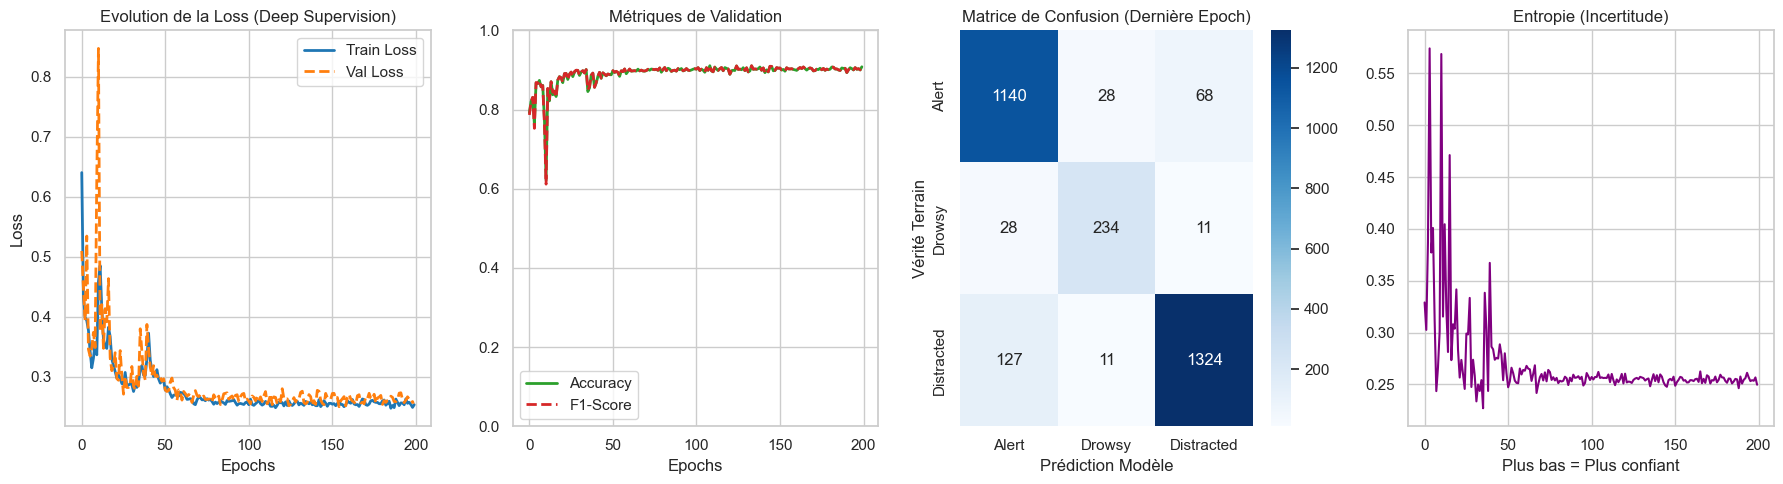


--- Rapport de Classification ---
              precision    recall  f1-score   support

       Alert       0.88      0.92      0.90      1236
      Drowsy       0.86      0.86      0.86       273
  Distracted       0.94      0.91      0.92      1462

    accuracy                           0.91      2971
   macro avg       0.89      0.90      0.89      2971
weighted avg       0.91      0.91      0.91      2971



In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_results(history, y_true, y_pred, classes=['Alert', 'Drowsy', 'Distracted']):
    # CORRECTION : On force la liste des labels attendus [0, 1, 2]
    # Cela évite le crash si une classe est manquante dans les prédictions
    all_labels = range(len(classes)) 

    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(1, 4, figsize=(18, 5))
    
    # 1. Courbes de Loss 
    ax[0].plot(history['train_loss'], label='Train Loss', color='tab:blue', linewidth=2)
    ax[0].plot(history['val_loss'], label='Val Loss', color='tab:orange', linewidth=2, linestyle='--')
    ax[0].set_title("Evolution de la Loss (Deep Supervision)")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend()
    
    # 2. Courbes de Métriques (Accuracy & F1)
    ax[1].plot(history['val_acc'], label='Accuracy', color='tab:green', linewidth=2)
    ax[1].plot(history['val_f1'], label='F1-Score', color='tab:red', linewidth=2, linestyle='--')
    ax[1].set_title("Métriques de Validation")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylim(0, 1.0)
    ax[1].legend()
    
    # 3. Matrice de Confusion 
    # AJOUT : paramètre 'labels' pour forcer la matrice 3x3 même si une classe manque
    cm = confusion_matrix(y_true, y_pred, labels=all_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[2], 
                xticklabels=classes, yticklabels=classes)
    ax[2].set_title("Matrice de Confusion (Dernière Epoch)")
    ax[2].set_ylabel("Vérité Terrain")
    ax[2].set_xlabel("Prédiction Modèle")


    # 4. Entropy
    ax[3].plot(history['val_entropy'], color='purple')
    ax[3].set_title("Entropie (Incertitude)")
    ax[3].set_xlabel("Plus bas = Plus confiant")
    
    plt.tight_layout()
    plt.show()
    
    # Rapport textuel détaillé
    print("\n--- Rapport de Classification ---")
    # AJOUT : paramètres 'labels' et 'zero_division'
    print(classification_report(y_true, y_pred, target_names=classes, labels=all_labels, zero_division=0))

# Afficher les graphiques
plot_results(history, y_true, y_pred)

### Fonction de Visualisation (CLS -> Patches)

In [8]:
def visualize_cls_attention(model, dataset, index=None):
    """
    Visualise l'attention portée par le token [CLS] sur les patches de l'image.
    """
    model.eval()
    if index is None: index = np.random.randint(0, len(dataset))
    
    img_tensor, label = dataset[index]
    
    # Prépare l'image pour affichage
    img_display = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_display = (img_display * 0.229 + 0.485).clip(0, 1)
    img_display = (img_display * 255).astype(np.uint8)
    
    # Inférence
    img_input = img_tensor.unsqueeze(0).to(CONFIG['device'])
    with torch.no_grad():
        _, attn_weights = model(img_input)
        
        # attn_weights: [B, Heads, 17, 17]
        # On veut: CLS (idx 0) -> Patches (idx 1 à 16)
        # On moyenne les têtes pour l'affichage global
        cls_attn = attn_weights[0, :, 0, 1:] # [Heads, 16]
        cls_attn = cls_attn.mean(dim=0)      # [16] (Moyenne sur les têtes)
        
        # Reshape en grille 4x4
        attn_grid = cls_attn.view(8, 8).cpu().numpy()

    # Upscaling pour overlay
    heatmap = cv2.resize(attn_grid, (64, 64), interpolation=cv2.INTER_CUBIC)
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    overlay = cv2.addWeighted(cv2.cvtColor(img_display, cv2.COLOR_RGB2BGR), 0.6, heatmap_color, 0.4, 0)
    
    # Affichage
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1); plt.imshow(img_display); plt.title("Originale")
    plt.subplot(1, 2, 2); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.title("Attention [CLS]")
    plt.show()

### Visualisation de l'Attention

Exemples de visualisations d'attention :


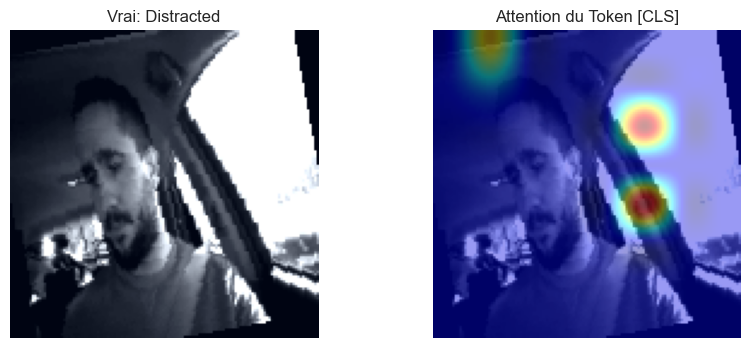

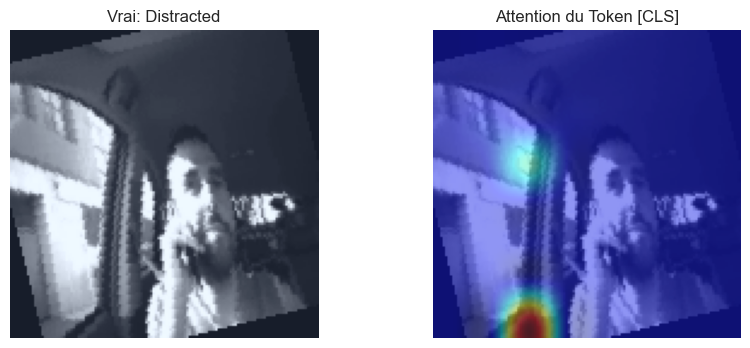

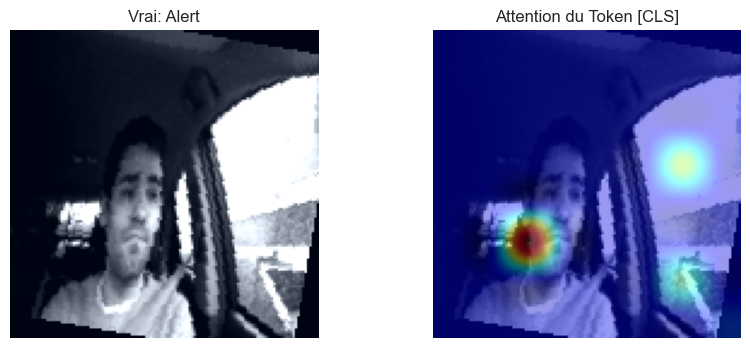

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_attention(model, dataset, index=None):
    model.eval()
    if index is None: index = np.random.randint(0, len(dataset))
    
    img_tensor, label = dataset[index]
    
    # Préparation image pour affichage
    img_display = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_display = (img_display * 0.229 + 0.485).clip(0, 1)
    img_display = (img_display * 255).astype(np.uint8)
    
    img_input = img_tensor.unsqueeze(0).to(CONFIG['device'])
    
    with torch.no_grad():
        # Le modèle retourne (outputs, attn_weights)
        _, attn_weights = model(img_input)
        
        # attn_weights shape est maintenant : [Batch, Heads, 17, 17]
        # (car 1 CLS + 16 Patches = 17 tokens)
        
        # On veut voir ce que le CLS (l'arbitre) regarde dans l'image.
        # Index 0 = CLS. Indices 1: = Les Patches de l'image.
        
        # On prend : Batch 0, Toutes les têtes, Ligne 0 (CLS), Colonnes 1 à fin (Patches)
        cls_attn = attn_weights[0, :, 0, 1:] # Shape [Heads, 16]
        
        # On fait la moyenne sur les têtes d'attention
        cls_attn = cls_attn.mean(dim=0) # Shape [16]
        
        # Maintenant on a bien 16 valeurs qu'on peut remettre en 4x4
        attn_grid = cls_attn.view(8, 8).cpu().numpy()

    # Upscaling et Colorisation
    heatmap = cv2.resize(attn_grid, (128, 128), interpolation=cv2.INTER_CUBIC)
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Overlay
    overlay = cv2.addWeighted(cv2.cvtColor(img_display, cv2.COLOR_RGB2BGR), 0.6, heatmap_color, 0.4, 0)
    
    # Affichage
    classes = {0: "Alert", 1: "Drowsy", 2: "Distracted"}
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_display)
    plt.title(f"Vrai: {classes[label.item()]}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title("Attention du Token [CLS]")
    plt.axis('off')
    plt.show()

# Test
print("Exemples de visualisations d'attention :")
for _ in range(3):
    visualize_attention(trained_model, val_ds)

### Chargement du meilleur modèle pour inférence

In [10]:
def load_best_model():
    print(f"Chargement du meilleur modèle depuis : {CONFIG['save_path']}")
    
    # 1. Recréer l'architecture
    model = DriverTRM(CONFIG)
    
    # 2. Charger les poids
    model.load_state_dict(torch.load(CONFIG['save_path'], map_location=CONFIG['device']))
    model.to(CONFIG['device'])
    model.eval()
    
    print("Modèle chargé avec succès. Prêt pour l'inférence Edge.")
    return model

best_model = load_best_model()

Chargement du meilleur modèle depuis : best_trm_model.pth
Modèle chargé avec succès. Prêt pour l'inférence Edge.
